# End-to-End Medical Image Processing Pipeline

This notebook demonstrates a pipeline that processes incoming medical images using three models:

1. **YOLO Model**: Detects objects and provides bounding boxes.
2. **SAM Model**: Performs segmentation using the image and bounding box.
3. **Classification Model**: Classifies the image.

The workflow is: **Image → YOLO (bbox) → SAM (segmentation) → Classification**.

In [1]:
# Import required libraries
import torch
from PIL import Image
import numpy as np
from utility import non_max_suppression, calculate_iou, extract_bbox_from_mask
import cv2
import glob
import pydicom as dicom
from ultralytics import YOLO
import matplotlib.pyplot as plt
# Example: import YOLO, SAM, and classification model loading utilities
# from yolov8 import YOLO
# from sam import SAM
# from classifier import Classifier

# Placeholder for actual model import paths

In [3]:
data_dir = './T4R-Biobanks'

# Gather file paths and labels
images = []
masks = []
file_paths = []

to_remove = [data_dir + '/Breast-US-018.dcm', data_dir + '/Breast-US-020.dcm', data_dir + '/Breast-US-061.dcm']

for item in glob.glob(data_dir + '/Breast-US-*.dcm'):
    if item in to_remove:
        print('Item Removed: ' + item)
        continue
    ds = dicom.dcmread(item)
    image = cv2.resize(ds.pixel_array[:,:,0], (256, 256))
    mask = cv2.resize(ds.pixel_array[:,:,2], (256, 256), interpolation=cv2.INTER_NEAREST)
    images.append(image)
    masks.append(mask)
    file_paths.append(item)

# Take 80% of the data for training using the stratified split
from sklearn.model_selection import train_test_split
train_files, test_files, train_labels, test_labels, train_paths, test_paths = train_test_split(
    images, masks, file_paths, train_size=0.8, random_state=42
)

train_files, val_files, train_labels, val_labels, train_paths, val_paths = train_test_split(
    train_files, train_labels, train_paths, train_size=0.8, random_state=42
)

Item Removed: ./T4R-Biobanks/Breast-US-020.dcm
Item Removed: ./T4R-Biobanks/Breast-US-018.dcm
Item Removed: ./T4R-Biobanks/Breast-US-018.dcm
Item Removed: ./T4R-Biobanks/Breast-US-061.dcm
Item Removed: ./T4R-Biobanks/Breast-US-061.dcm


In [35]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_TARGET_LONGEST_SIDE = 1024 # SAM 2 typically expects images resized this way
BATCH_SIZE = 1 # Sticking to batch_size 1 to align with SAM2 script's predictor logic
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 4e-5 # From SAM2 script
EPOCHS = 50
RANDOM_SEED = 42
EARLY_STOPPING_PATIENCE = 5
MODEL_SAVE_PATH = "sam2_finetuned_ultrasound_best.pt"
SAM2_CHECKPOINT_PATH = "./sam2_finetuned_ultrasound_best.pt" # e.g., sam2_hiera_base_plus_1bn.pt
SAM2_MODEL_CONFIG = "configs/sam2.1/sam2.1_hiera_b+.yaml" # e.g., sam2_hiera_b+.yaml

In [36]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [39]:
sam2_model = build_sam2(SAM2_MODEL_CONFIG, None, device=DEVICE)  # Don't load checkpoint yet
state_dict = torch.load(SAM2_CHECKPOINT_PATH, map_location="cpu")
sam2_model.load_state_dict(state_dict)
sam2_model = sam2_model.to(DEVICE)
predictor = SAM2ImagePredictor(sam2_model)

In [40]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
    ]),
    'val': None,
    'test': None,
}

In [41]:
class UltrasoundArrayDataset(Dataset):
    def __init__(self, image_arrays, mask_arrays, image_ids=None, transform=None, image_longest_side=1024):
        """
        Args:
            image_arrays (list or np.ndarray): List/array of image pixel arrays (e.g., HxW grayscale).
            mask_arrays (list or np.ndarray): List/array of mask pixel arrays (e.g., HxW binary).
            image_ids (list, optional): List of image identifiers. Defaults to indices.
            transform (callable, optional): Optional transform to be applied on a sample.
            image_longest_side (int): Target size for the longest side of the image.
        """
        self.image_arrays = image_arrays
        self.mask_arrays = mask_arrays
        self.transform = transform
        self.image_longest_side = image_longest_side
        if image_ids is None:
            self.image_ids = [str(i) for i in range(len(image_arrays))]
        else:
            self.image_ids = image_ids

        if len(self.image_arrays) != len(self.mask_arrays):
            raise ValueError("image_arrays and mask_arrays must have the same length.")
        if self.image_ids is not None and len(self.image_arrays) != len(self.image_ids):
            raise ValueError("image_arrays and image_ids must have the same length.")


    def __len__(self):
        return len(self.image_arrays)

    def _resize_image_and_mask(self, image, mask):
        # Ensure image and mask are 2D or 3D (H, W) or (H, W, C) before getting shape
        img_h, img_w = image.shape[0], image.shape[1] # image is expected to be HxW or HxWxC

        scale = self.image_longest_side / max(img_h, img_w)
        new_h, new_w = int(img_h * scale), int(img_w * scale)

        resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        # Ensure mask is 2D for resizing
        if mask.ndim == 3 and mask.shape[-1] == 1: # HxWx1
            mask_2d = mask.squeeze(-1)
        elif mask.ndim == 2: # HxW
            mask_2d = mask
        else:
            raise ValueError(f"Unexpected mask shape for resizing: {mask.shape}")

        resized_mask = cv2.resize(mask_2d, (new_w, new_h), interpolation=cv2.INTER_NEAREST)
        return resized_image, resized_mask

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        try:
            image_arr_orig = self.image_arrays[idx].astype(np.float32)
            mask_arr_orig = self.mask_arrays[idx].astype(np.uint8) # Assume masks are already somewhat binary (0s and some positive value)

            # Handle image dimensions (e.g., if grayscale HxW, make it HxWx1 for consistency)
            if image_arr_orig.ndim == 2: # Grayscale HxW
                image_arr = image_arr_orig # Keep as is for now, convert to RGB later
            elif image_arr_orig.ndim == 3 and image_arr_orig.shape[-1] == 1: # Grayscale HxWx1
                image_arr = image_arr_orig.squeeze(-1)
            elif image_arr_orig.ndim == 3 and image_arr_orig.shape[-1] >= 3: # RGB or RGBA, convert to grayscale
                 image_arr = cv2.cvtColor(image_arr_orig, cv2.COLOR_RGB2GRAY if image_arr_orig.shape[-1] == 3 else cv2.COLOR_RGBA2GRAY)
            else:
                raise ValueError(f"Unsupported image array shape: {image_arr_orig.shape} for image_id {image_id}")

            # Normalize image to 0-1 (basic normalization)
            image_arr = (image_arr - np.min(image_arr)) / (np.max(image_arr) - np.min(image_arr) + 1e-6)
            image_arr_uint8 = (image_arr * 255).astype(np.uint8)

            # Binarize the mask (ensure it's 0 or 1)
            # If masks are already 0/1, this won't change them. If they are 0/255, it will fix.
            mask_binary = (mask_arr_orig > 0).astype(np.uint8)
            if mask_binary.ndim == 3 and mask_binary.shape[-1] == 1: # Ensure 2D mask if HxWx1
                mask_binary = mask_binary.squeeze(-1)
            elif mask_binary.ndim != 2:
                 raise ValueError(f"Unsupported mask array shape after binarization: {mask_binary.shape} for image_id {image_id}")


            # Resize image and mask
            image_resized_uint8, mask_resized_binary = self._resize_image_and_mask(image_arr_uint8, mask_binary)

            # Prepare image for SAM: Convert grayscale to 3-channel RGB-like
            image_for_sam = cv2.cvtColor(image_resized_uint8, cv2.COLOR_GRAY2RGB)
            original_image_for_viz = image_for_sam.copy()

            if self.transform:
                pil_image = TF.to_pil_image(image_for_sam)
                # Mask needs to be uint8, single channel (0 or 255 for PIL) for these transforms
                pil_mask = TF.to_pil_image(mask_resized_binary * 255)

                if isinstance(self.transform, transforms.Compose):
                    if any(isinstance(t, transforms.RandomHorizontalFlip) for t in self.transform.transforms) and torch.rand(1).item() < 0.5 :
                        pil_image = TF.hflip(pil_image)
                        pil_mask = TF.hflip(pil_mask)
                    if any(isinstance(t, transforms.RandomVerticalFlip) for t in self.transform.transforms) and torch.rand(1).item() < 0.5 :
                        pil_image = TF.vflip(pil_image)
                        pil_mask = TF.vflip(pil_mask)

                image_for_sam = np.array(pil_image)
                mask_augmented_np = np.array(pil_mask)
                mask_resized_binary = (mask_augmented_np > 0).astype(np.uint8)

            y_indices, x_indices = np.where(mask_resized_binary > 0)
            if len(y_indices) == 0:
                h, w = mask_resized_binary.shape
                bbox_prompt = np.array([0, 0, w - 1, h - 1], dtype=np.float32)
            else:
                x_min, x_max = np.min(x_indices), np.max(x_indices)
                y_min, y_max = np.min(y_indices), np.max(y_indices)
                bbox_prompt = np.array([x_min, y_min, x_max, y_max], dtype=np.float32)

            gt_mask_tensor = torch.from_numpy(mask_resized_binary.copy()).unsqueeze(0).float()

            return {
                "image_for_sam": image_for_sam,
                "gt_mask_tensor": gt_mask_tensor,
                "bbox_prompt": torch.from_numpy(bbox_prompt).float(),
                "image_id": image_id,
                "original_image_for_viz": original_image_for_viz
            }

        except Exception as e:
            print(f"Error processing item for image_id {image_id}: {e}")
            dummy_h, dummy_w = (256,256)
            return {
                "image_for_sam": np.zeros((dummy_h, dummy_w, 3), dtype=np.uint8),
                "gt_mask_tensor": torch.zeros((1, dummy_h, dummy_w), dtype=torch.float32),
                "bbox_prompt": torch.tensor([0,0,dummy_w-1,dummy_h-1], dtype=torch.float32),
                "image_id": f"error_sample_{image_id}",
                "original_image_for_viz": np.zeros((dummy_h, dummy_w, 3), dtype=np.uint8)
            }

In [42]:
test_dataset = UltrasoundArrayDataset(test_files, test_labels,
                                      transform=data_transforms['test'], image_longest_side=IMAGE_TARGET_LONGEST_SIDE)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [43]:
def iou_metric_pytorch(logits, targets, smooth=1e-5):
    probs = torch.sigmoid(logits)
    preds_binary = (probs > 0.5).float()

    iflat = preds_binary.contiguous().view(preds_binary.size(0), -1)
    tflat = targets.contiguous().view(targets.size(0), -1)

    intersection = (iflat * tflat).sum(dim=1)
    union = iflat.sum(dim=1) + tflat.sum(dim=1) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

In [45]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        iflat = probs.contiguous().view(probs.size(0), -1)
        tflat = targets.contiguous().view(targets.size(0), -1)

        intersection = (iflat * tflat).sum(dim=1)
        dice_score = (2. * intersection + self.smooth) / (iflat.sum(dim=1) + tflat.sum(dim=1) + self.smooth)
        return 1. - dice_score.mean()

In [46]:
segmentation_loss_fn = DiceLoss().to(DEVICE)

In [55]:
import tensorflow as tf

classification_model = tf.keras.models.load_model('vgg16_fold5_best.keras')

E0000 00:00:1748103412.887326    1918 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748103412.920357    1918 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748103413.181034    1918 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748103413.181097    1918 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748103413.181101    1918 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748103413.181103    1918 computation_placer.cc:177] computation placer already registered. Please check linka

In [56]:
def cast_images(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.expand_dims(image, axis=-1)
    image = tf.repeat(image, 3, axis=-1)

    return image, label


--- Evaluating on Test Set (YOLO BBoxes) ---


Testing:   0%|          | 0/32 [00:00<?, ?it/s]


0: 416x416 3 tumors, 101.7ms
Speed: 3.1ms preprocess, 101.7ms inference, 3.2ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Testing:   3%|▎         | 1/32 [00:00<00:07,  4.03it/s]


0: 416x416 8 tumors, 11.5ms
Speed: 1.5ms preprocess, 11.5ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Testing:   6%|▋         | 2/32 [00:00<00:05,  5.63it/s]


0: 416x416 5 tumors, 10.6ms
Speed: 1.4ms preprocess, 10.6ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Testing:   9%|▉         | 3/32 [00:00<00:04,  6.49it/s]


0: 416x416 7 tumors, 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Testing:  12%|█▎        | 4/32 [00:00<00:03,  7.02it/s]


0: 416x416 8 tumors, 11.2ms
Speed: 1.7ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Testing:  16%|█▌        | 5/32 [00:00<00:03,  7.38it/s]


0: 416x416 6 tumors, 11.2ms
Speed: 1.3ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Testing:  19%|█▉        | 6/32 [00:00<00:03,  7.65it/s]


0: 416x416 5 tumors, 11.3ms
Speed: 1.4ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Testing:  22%|██▏       | 7/32 [00:00<00:03,  7.84it/s]


0: 416x416 3 tumors, 11.6ms
Speed: 1.4ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Testing:  25%|██▌       | 8/32 [00:01<00:03,  7.95it/s]


0: 416x416 6 tumors, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Testing:  28%|██▊       | 9/32 [00:01<00:02,  8.07it/s]


0: 416x416 3 tumors, 10.3ms
Speed: 1.3ms preprocess, 10.3ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Testing:  31%|███▏      | 10/32 [00:01<00:02,  8.12it/s]


0: 416x416 4 tumors, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Testing:  34%|███▍      | 11/32 [00:01<00:02,  8.10it/s]


0: 416x416 21 tumors, 11.0ms
Speed: 1.6ms preprocess, 11.0ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Testing:  38%|███▊      | 12/32 [00:01<00:02,  8.03it/s]


0: 416x416 21 tumors, 10.8ms
Speed: 1.7ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Testing:  41%|████      | 13/32 [00:01<00:02,  8.06it/s]


0: 416x416 6 tumors, 11.9ms
Speed: 1.6ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Testing:  44%|████▍     | 14/32 [00:01<00:02,  8.05it/s]


0: 416x416 4 tumors, 11.3ms
Speed: 1.6ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Testing:  47%|████▋     | 15/32 [00:01<00:02,  8.08it/s]


0: 416x416 3 tumors, 11.0ms
Speed: 1.4ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Testing:  50%|█████     | 16/32 [00:02<00:01,  8.10it/s]


0: 416x416 8 tumors, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Testing:  53%|█████▎    | 17/32 [00:02<00:01,  8.10it/s]


0: 416x416 7 tumors, 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Testing:  56%|█████▋    | 18/32 [00:02<00:01,  8.09it/s]


0: 416x416 5 tumors, 11.4ms
Speed: 1.4ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Testing:  59%|█████▉    | 19/32 [00:02<00:01,  8.11it/s]


0: 416x416 1 tumor, 10.8ms
Speed: 1.7ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Testing:  62%|██████▎   | 20/32 [00:02<00:01,  8.14it/s]


0: 416x416 1 tumor, 11.1ms
Speed: 1.7ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Testing:  66%|██████▌   | 21/32 [00:02<00:01,  8.03it/s]


0: 416x416 12 tumors, 12.0ms
Speed: 1.6ms preprocess, 12.0ms inference, 2.7ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Testing:  69%|██████▉   | 22/32 [00:02<00:01,  8.07it/s]


0: 416x416 5 tumors, 10.5ms
Speed: 1.2ms preprocess, 10.5ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Testing:  72%|███████▏  | 23/32 [00:02<00:01,  8.15it/s]


0: 416x416 14 tumors, 11.2ms
Speed: 1.4ms preprocess, 11.2ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Testing:  75%|███████▌  | 24/32 [00:03<00:00,  8.14it/s]


0: 416x416 2 tumors, 10.7ms
Speed: 1.5ms preprocess, 10.7ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Testing:  78%|███████▊  | 25/32 [00:03<00:00,  7.92it/s]


0: 416x416 6 tumors, 11.2ms
Speed: 2.2ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Testing:  81%|████████▏ | 26/32 [00:03<00:00,  7.72it/s]


0: 416x416 3 tumors, 10.0ms
Speed: 1.3ms preprocess, 10.0ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Testing:  84%|████████▍ | 27/32 [00:03<00:00,  7.89it/s]


0: 416x416 10 tumors, 13.5ms
Speed: 1.8ms preprocess, 13.5ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Testing:  88%|████████▊ | 28/32 [00:03<00:00,  7.86it/s]


0: 416x416 1 tumor, 10.6ms
Speed: 1.3ms preprocess, 10.6ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Testing:  91%|█████████ | 29/32 [00:03<00:00,  7.96it/s]


0: 416x416 1 tumor, 11.0ms
Speed: 1.3ms preprocess, 11.0ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Testing:  94%|█████████▍| 30/32 [00:03<00:00,  7.99it/s]


0: 416x416 5 tumors, 10.3ms
Speed: 1.3ms preprocess, 10.3ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Testing:  97%|█████████▋| 31/32 [00:03<00:00,  8.06it/s]


0: 416x416 3 tumors, 11.7ms
Speed: 1.6ms preprocess, 11.7ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Testing: 100%|██████████| 32/32 [00:04<00:00,  7.81it/s]

Total Image Count: 32
Total Test Time: 3.8313660621643066 seconds
Average Test Time per Image: 0.1197 seconds (Std: 0.0182)
Test Set Performance: IoU=0.7327, IoU Std=0.2593


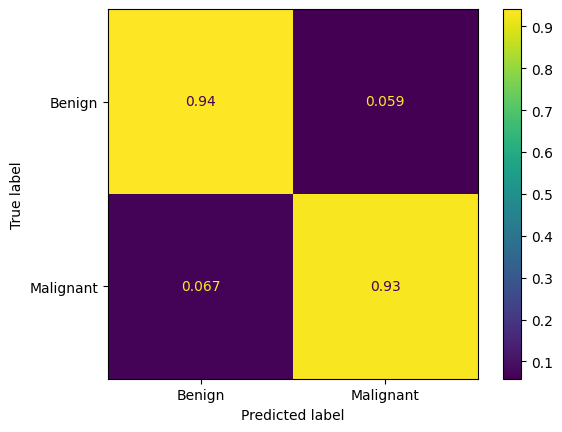

In [79]:
from tqdm.auto import tqdm
import time

# --- Evaluating on Test Set with YOLO Bounding Boxes ---
print("\n--- Evaluating on Test Set (YOLO BBoxes) ---")
predictor.model.eval()
test_losses, test_ious, test_accuracies = [], [], []
all_gt_flat_test, all_pred_flat_test = [], []

test_class_labels = [0 if dicom.dcmread(item).ClinicalTrialSeriesID.split(';')[2] == 'Benign' else 1 for item in test_paths]
test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_class_labels))
test_ds = test_ds.map(cast_images, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

predictions, test_labels = [], []
test_time = []

progress_bar_test = tqdm(test_loader, desc="Testing")
with torch.no_grad():
    for batch, b in zip(progress_bar_test, test_ds):
        t0 = time.time()
        image_for_sam_np = batch["image_for_sam"][0].numpy()
        gt_mask_tensor = batch["gt_mask_tensor"].to(DEVICE)

        # Get YOLO bounding box for this image
        # Convert image to 3-channel if needed
        if image_for_sam_np.ndim == 2:
            img_yolo = np.repeat(image_for_sam_np[:, :, np.newaxis], 3, axis=2)
        else:
            img_yolo = image_for_sam_np
        results = model.predict(source=img_yolo, save=False, imgsz=416, conf=0.01, device=0)
        predicted_boxes = results[0].boxes
        nms_boxes = non_max_suppression(predicted_boxes, iou_threshold=0.2)
        if not nms_boxes:
            print("No YOLO box found for this image. Skipping.")
            continue
        # Use the highest confidence box
        bbox = nms_boxes[0]
        h, w = img_yolo.shape[:2]
        # If normalized, convert to pixel
        if max(bbox) <= 1.0:
            x1 = int(bbox[0] * w)
            y1 = int(bbox[1] * h)
            x2 = int(bbox[2] * w)
            y2 = int(bbox[3] * h)
        else:
            x1, y1, x2, y2 = map(int, bbox)
        bbox_prompt_tensor = torch.tensor([[x1, y1, x2, y2]], dtype=torch.float32, device=DEVICE)

        with torch.amp.autocast(device_type=DEVICE.split(':')[0], enabled=(DEVICE=="cuda")):
            predictor.set_image(image_for_sam_np)
            boxes_for_encoder = bbox_prompt_tensor.unsqueeze(1)
            sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(points=None, boxes=boxes_for_encoder, masks=None)

            if predictor._features is None or "image_embed" not in predictor._features or "high_res_feats" not in predictor._features:
                print("Error: Predictor features (image_embed or high_res_feats) not set during testing.")
                continue

            high_res_features_test = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]

            low_res_masks, _, _, _ = predictor.model.sam_mask_decoder(
                image_embeddings=predictor._features["image_embed"],
                image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False,
                high_res_features=high_res_features_test,
                repeat_image=False
            )
            target_hw = gt_mask_tensor.shape[-2:]
            prd_masks_logits_upscaled = TF.resize(low_res_masks, list(target_hw),
                                                  interpolation=TF.InterpolationMode.BILINEAR,
                                                  antialias=True)

            loss = segmentation_loss_fn(prd_masks_logits_upscaled, gt_mask_tensor)
        
        # Classification prediction on a batch of images
        
        prediction = classification_model.predict(b[0])
        prediction = (prediction > 0.5).astype(int)
        predictions.extend(prediction)
        test_labels.extend(b[1].numpy())
        # Calculate IoU and accuracy
        iou = iou_metric_pytorch(prd_masks_logits_upscaled, gt_mask_tensor)
        test_ious.append(iou.item())
        t1 = time.time()
        test_time.append(t1 - t0)


avg_test_iou = np.mean(test_ious) if test_ious else 0
avg_std_iou = np.std(test_ious) if test_ious else 0
avg_time = np.mean(test_time) if test_time else 0
avg_time_std = np.std(test_time) if test_time else 0
total_time = sum(test_time)
print(f"Total Image Count: {len(test_files)}")
print(f"Total Test Time: {total_time} seconds")
print(f"Average Test Time per Image: {avg_time:.4f} seconds (Std: {avg_time_std:.4f})")

print(f"Test Set Performance: IoU={avg_test_iou:.4f}, IoU Std={avg_std_iou:.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_class_labels, predictions, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant']).plot()


0: 416x416 8 tumors, 45.6ms
Speed: 2.1ms preprocess, 45.6ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)


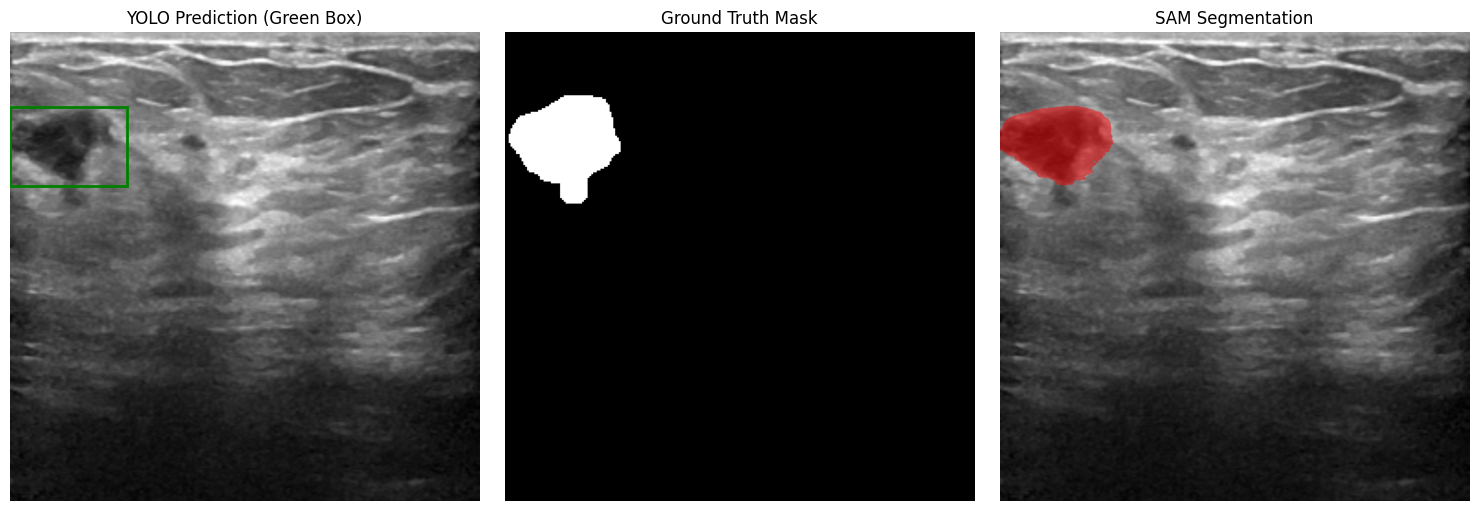


0: 416x416 3 tumors, 11.5ms
Speed: 1.4ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)


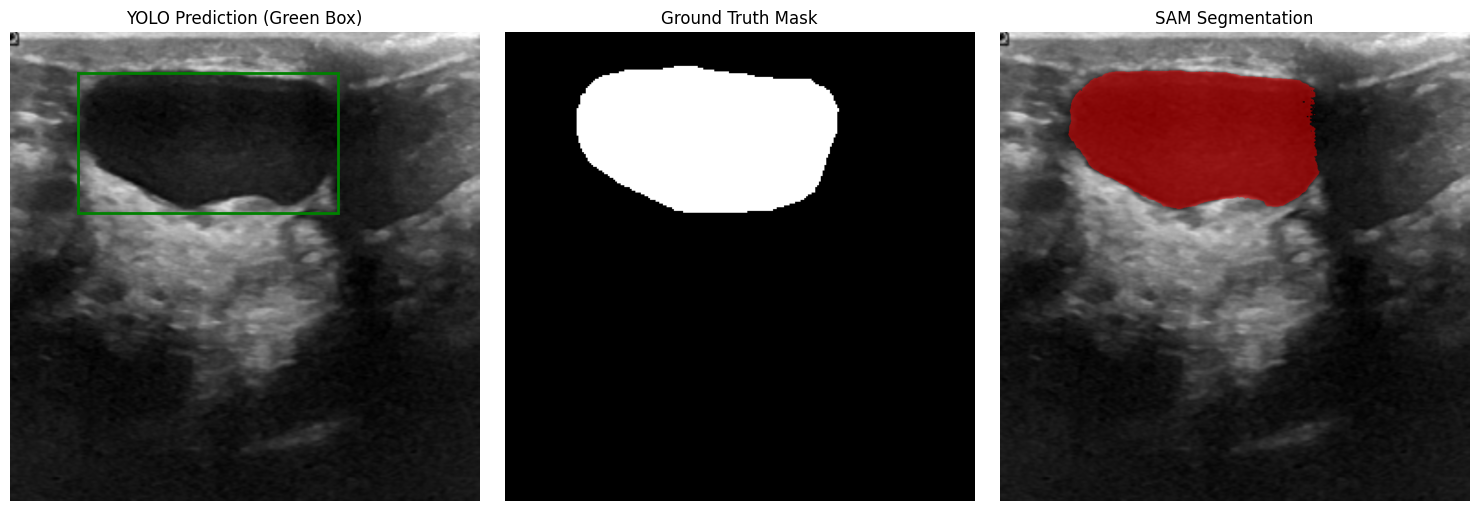


0: 416x416 3 tumors, 10.7ms
Speed: 1.3ms preprocess, 10.7ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)


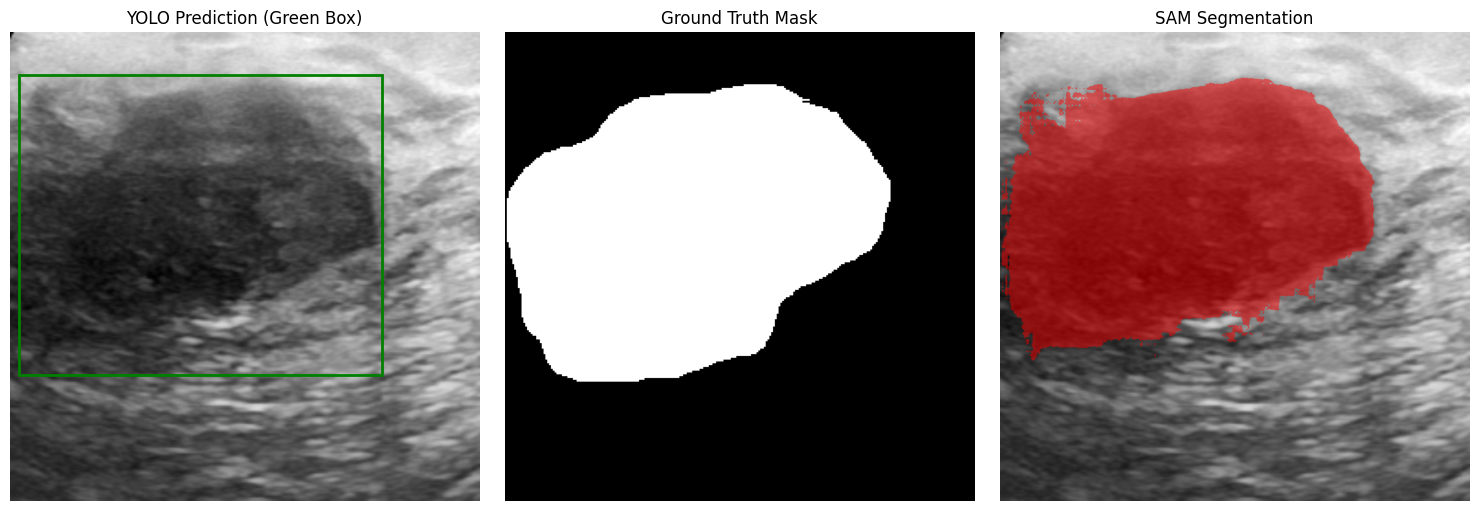


0: 416x416 1 tumor, 10.6ms
Speed: 1.2ms preprocess, 10.6ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)


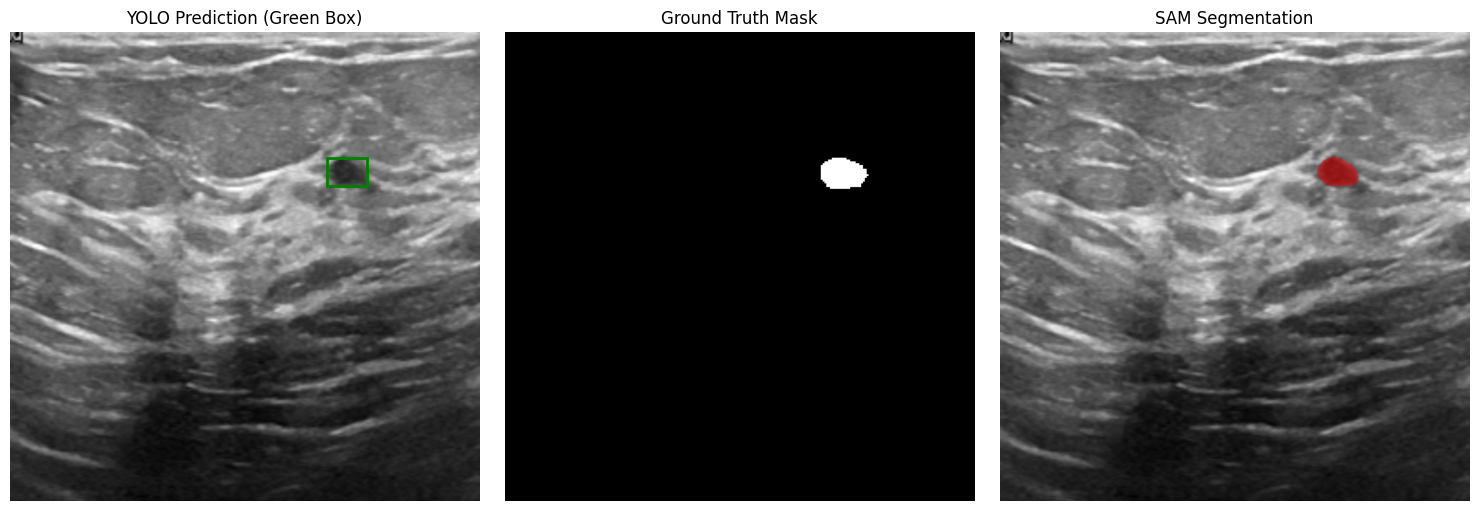


0: 416x416 2 tumors, 11.0ms
Speed: 1.3ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)


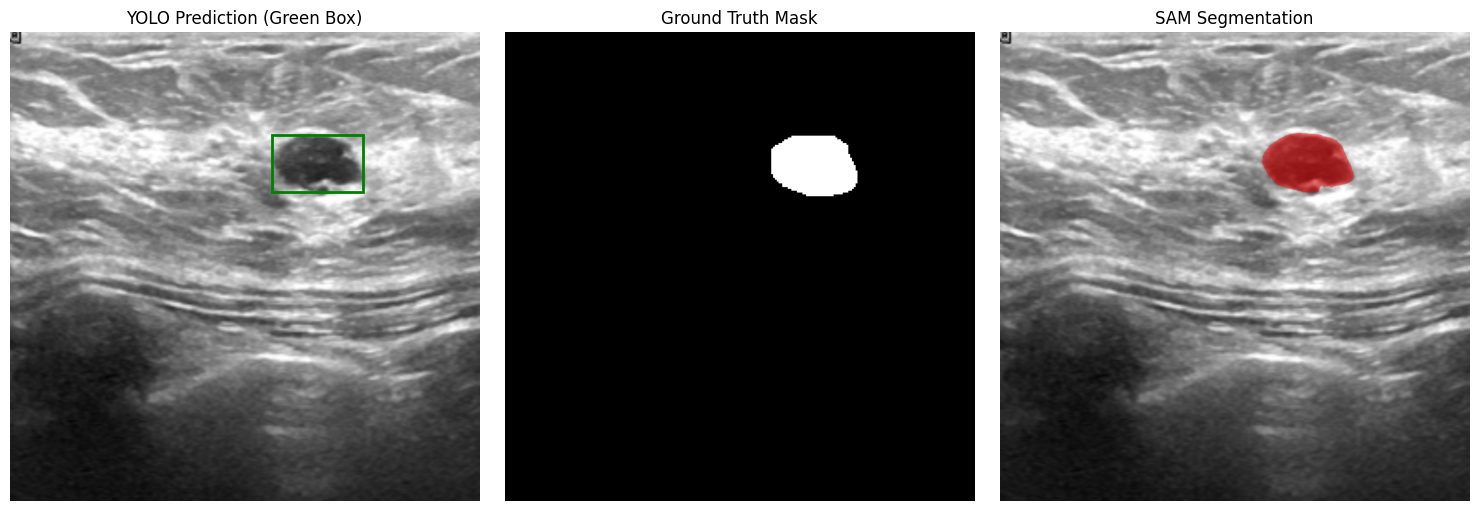


0: 416x416 5 tumors, 9.7ms
Speed: 1.4ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)


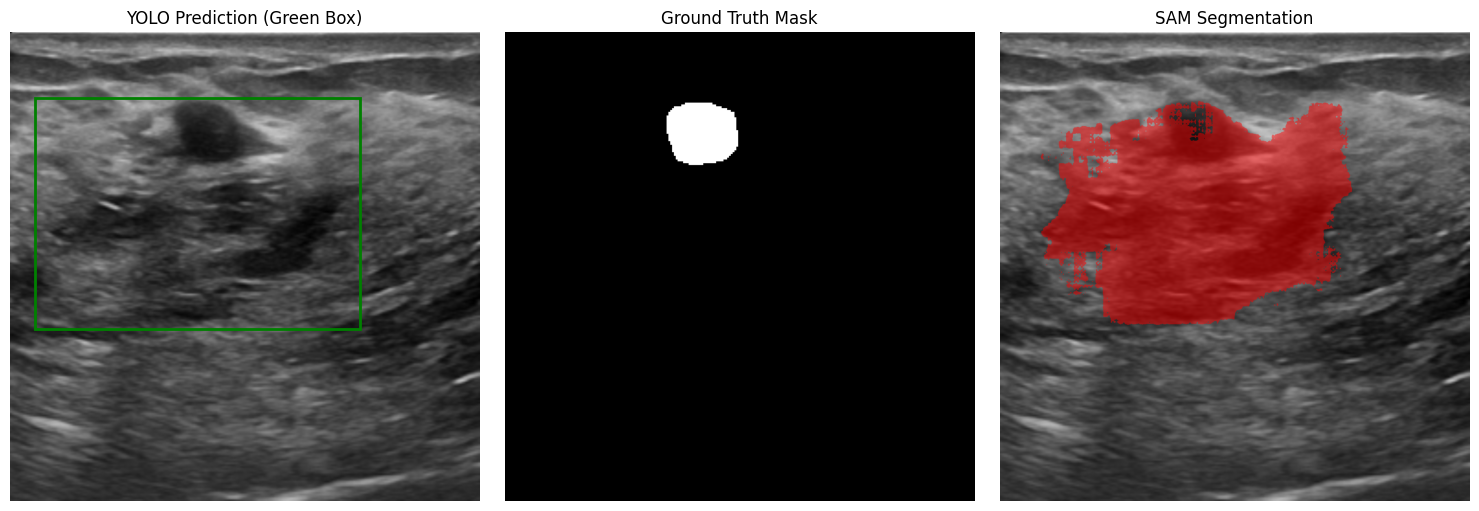


0: 416x416 8 tumors, 10.1ms
Speed: 1.5ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)


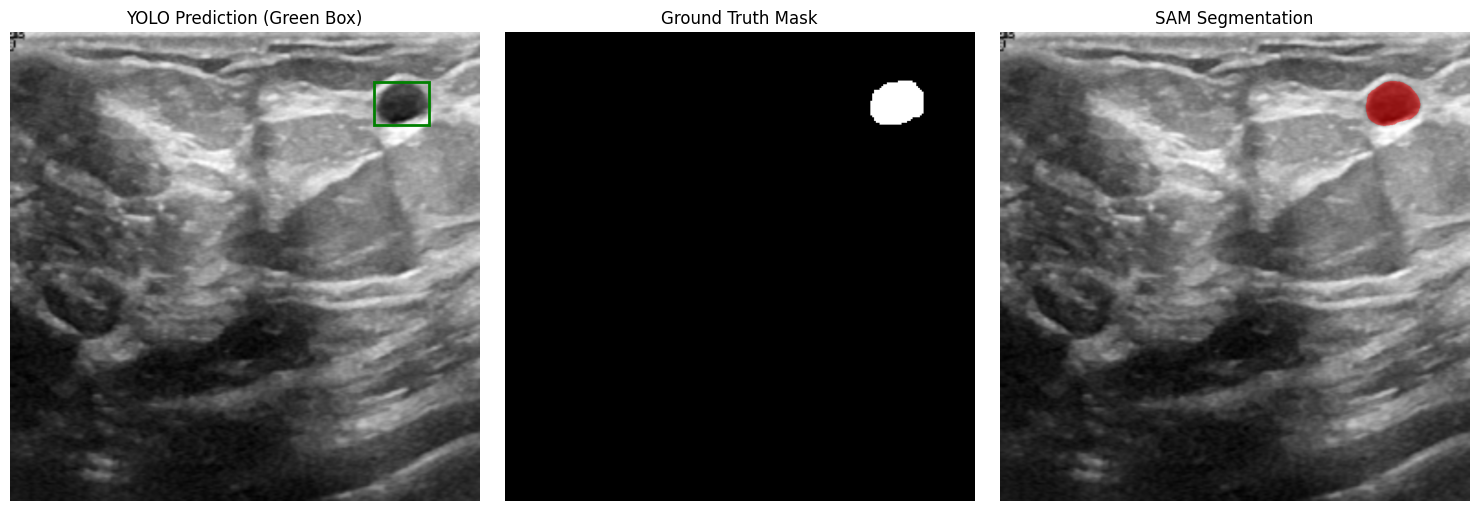


0: 416x416 10 tumors, 16.5ms
Speed: 2.2ms preprocess, 16.5ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)


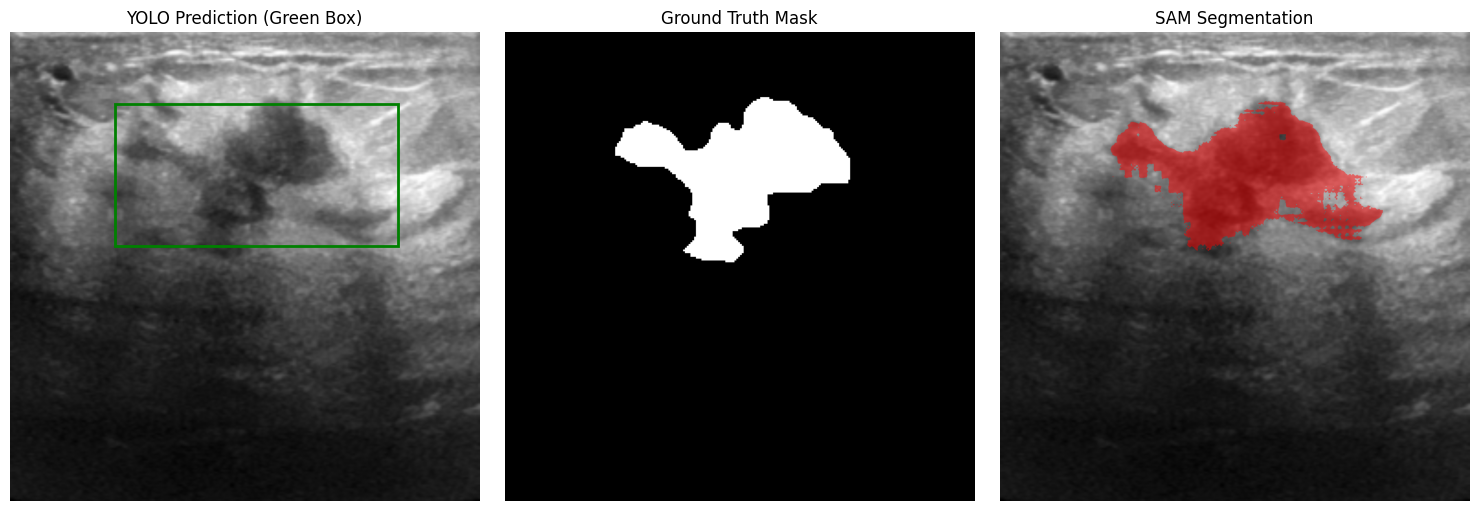


0: 416x416 3 tumors, 11.5ms
Speed: 1.6ms preprocess, 11.5ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)


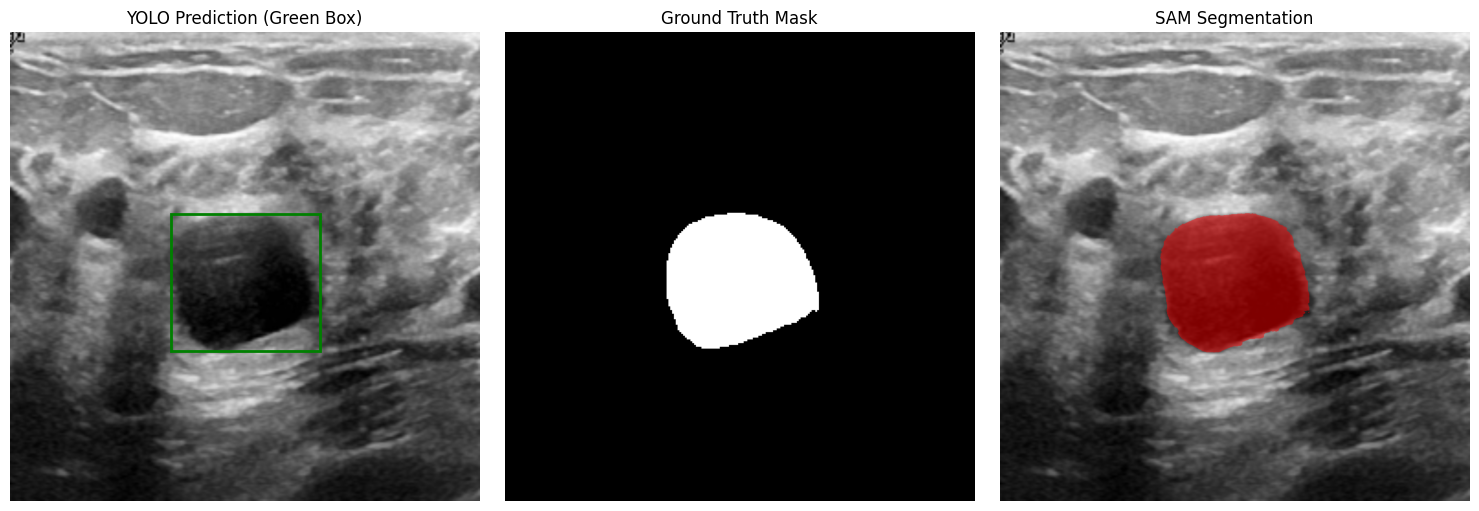


0: 416x416 4 tumors, 10.6ms
Speed: 1.1ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)


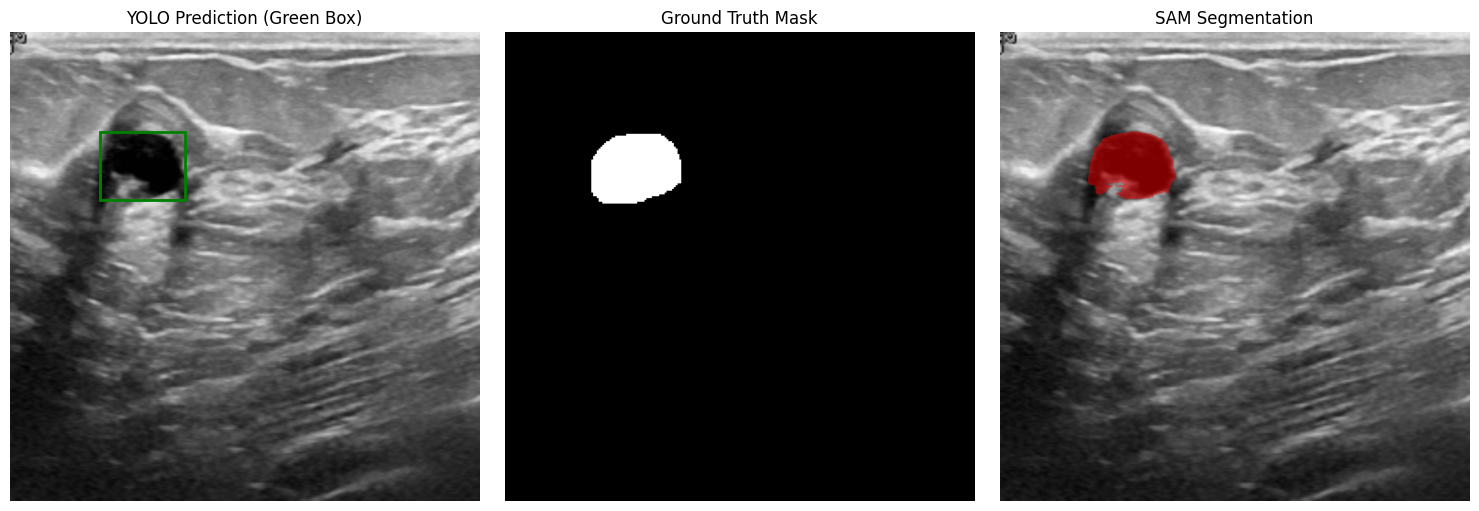


0: 416x416 1 tumor, 11.2ms
Speed: 1.2ms preprocess, 11.2ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)


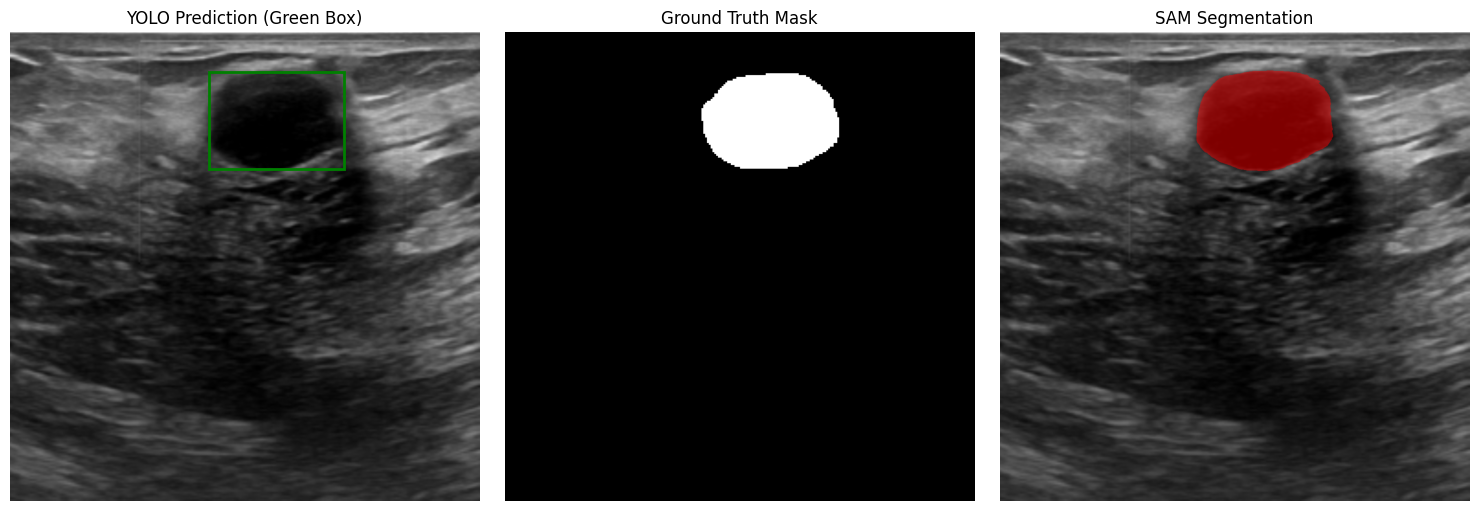


0: 416x416 21 tumors, 9.8ms
Speed: 1.5ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)


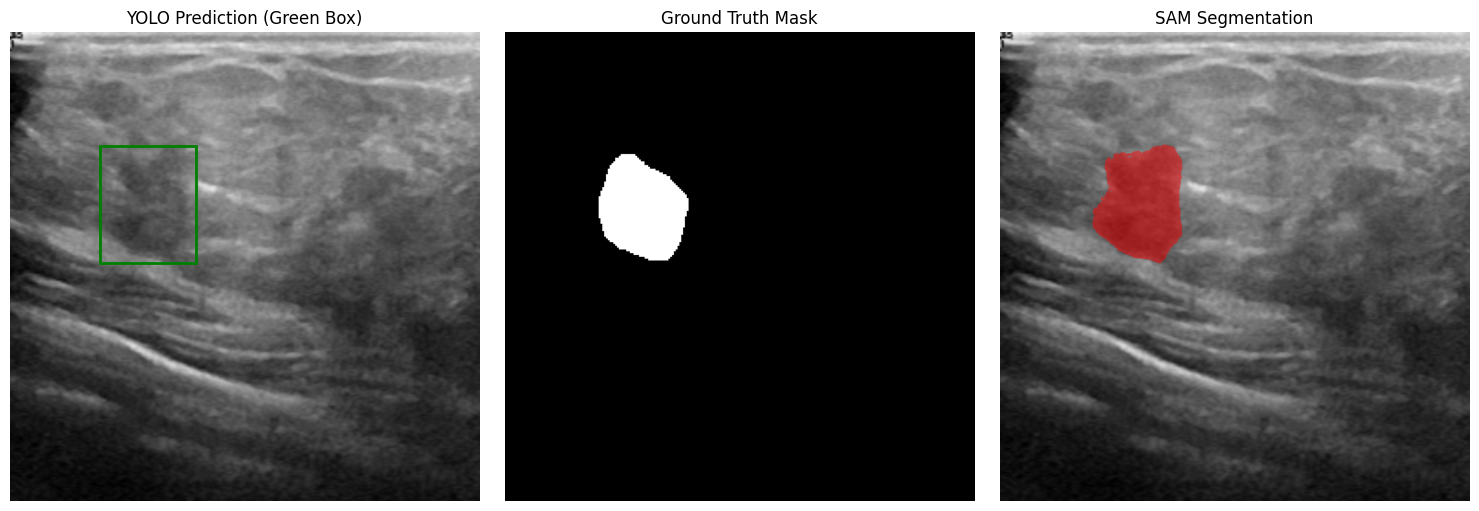


0: 416x416 6 tumors, 9.8ms
Speed: 1.4ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)


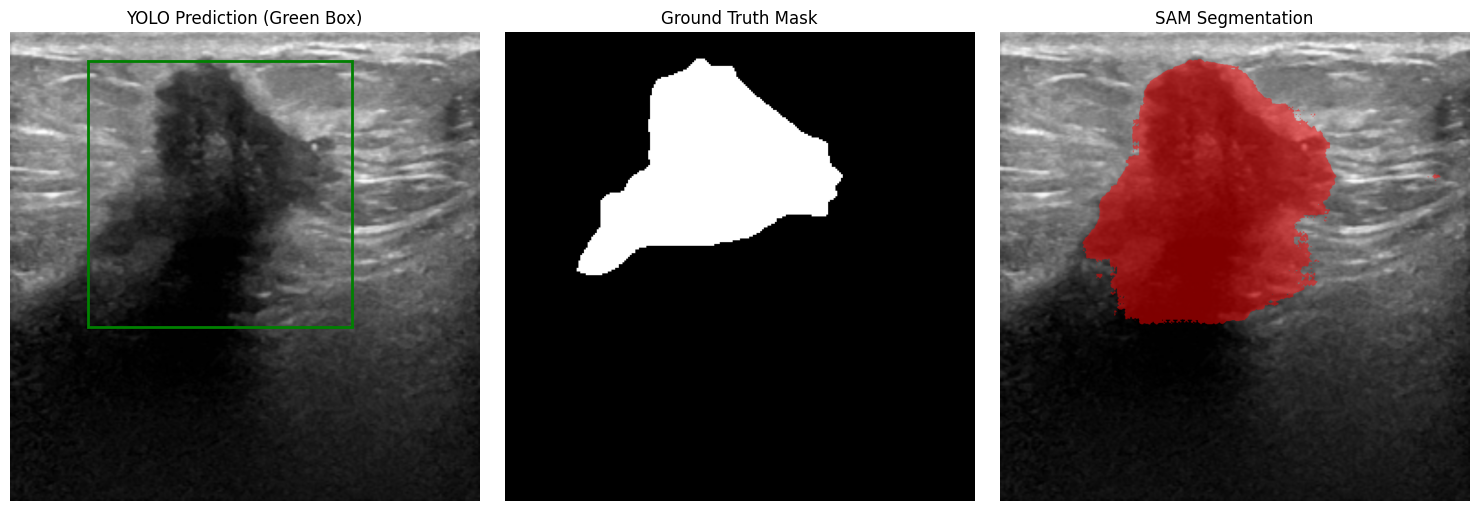


0: 416x416 3 tumors, 10.3ms
Speed: 1.1ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)


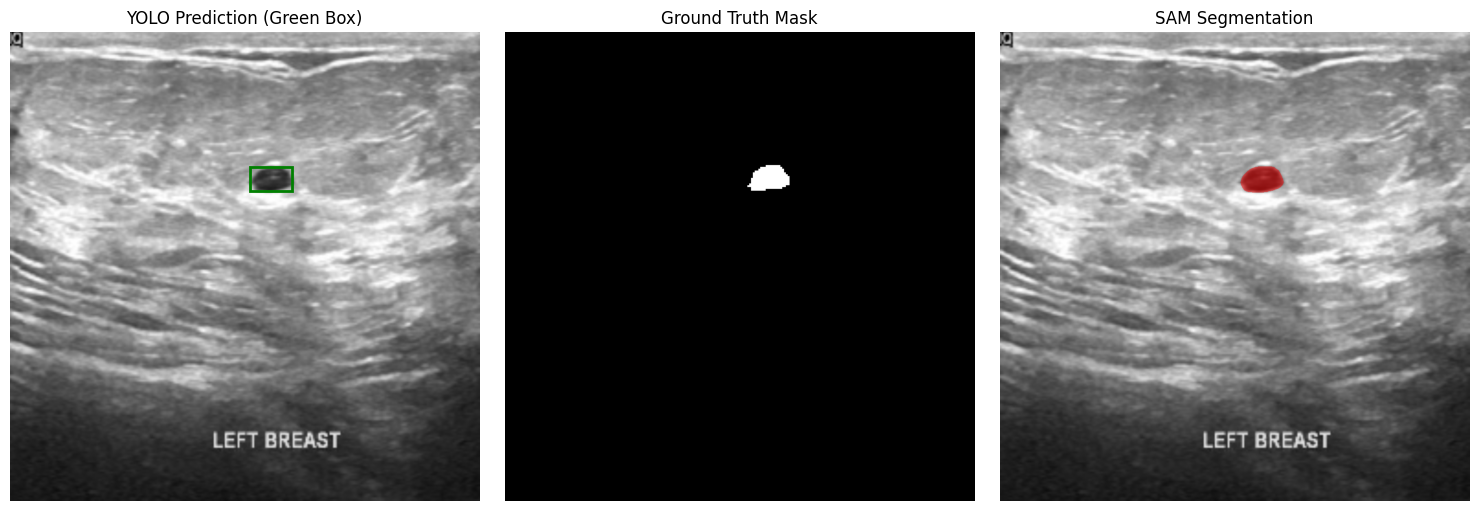


0: 416x416 8 tumors, 10.2ms
Speed: 1.2ms preprocess, 10.2ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)


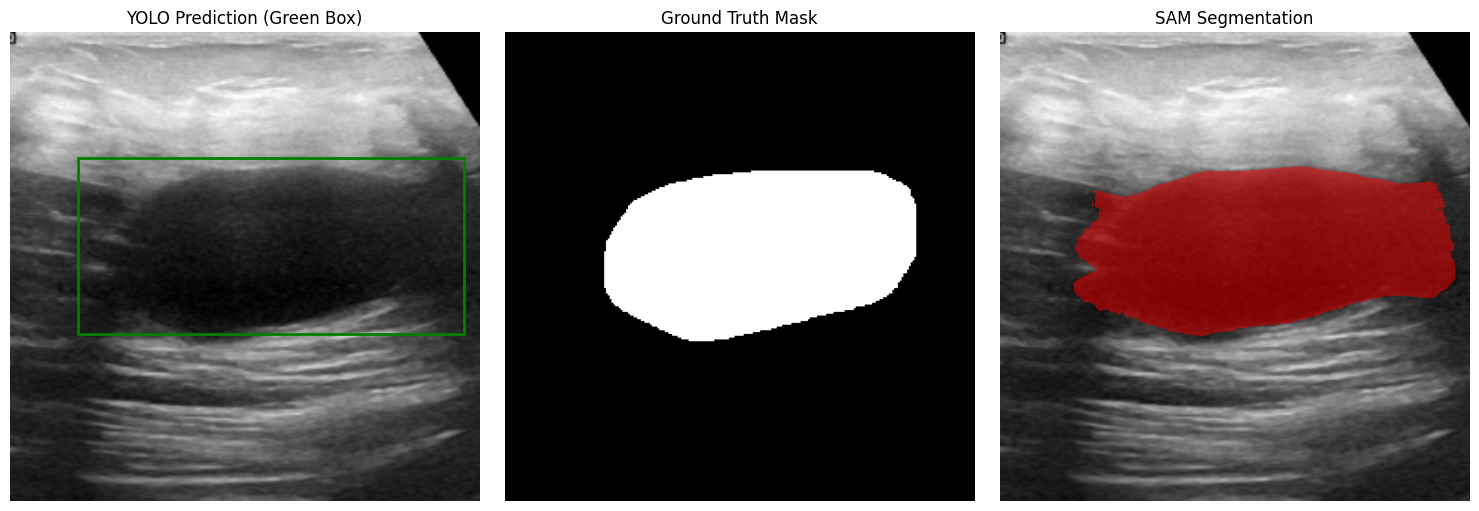


0: 416x416 7 tumors, 10.4ms
Speed: 1.2ms preprocess, 10.4ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)


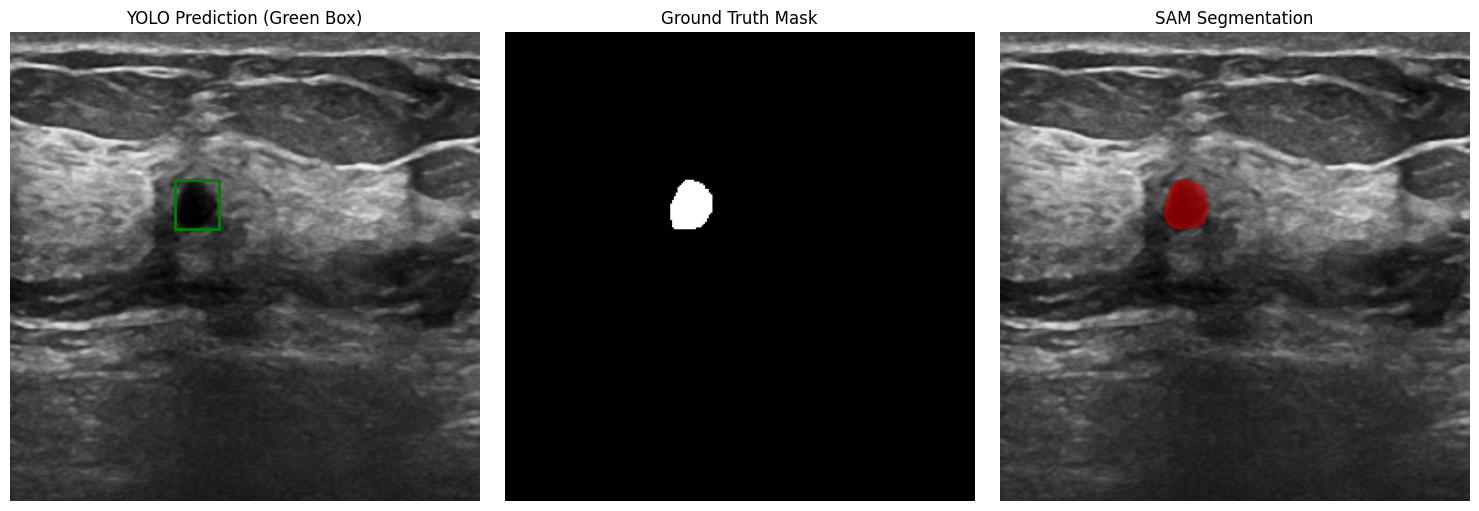


0: 416x416 3 tumors, 10.6ms
Speed: 1.3ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)


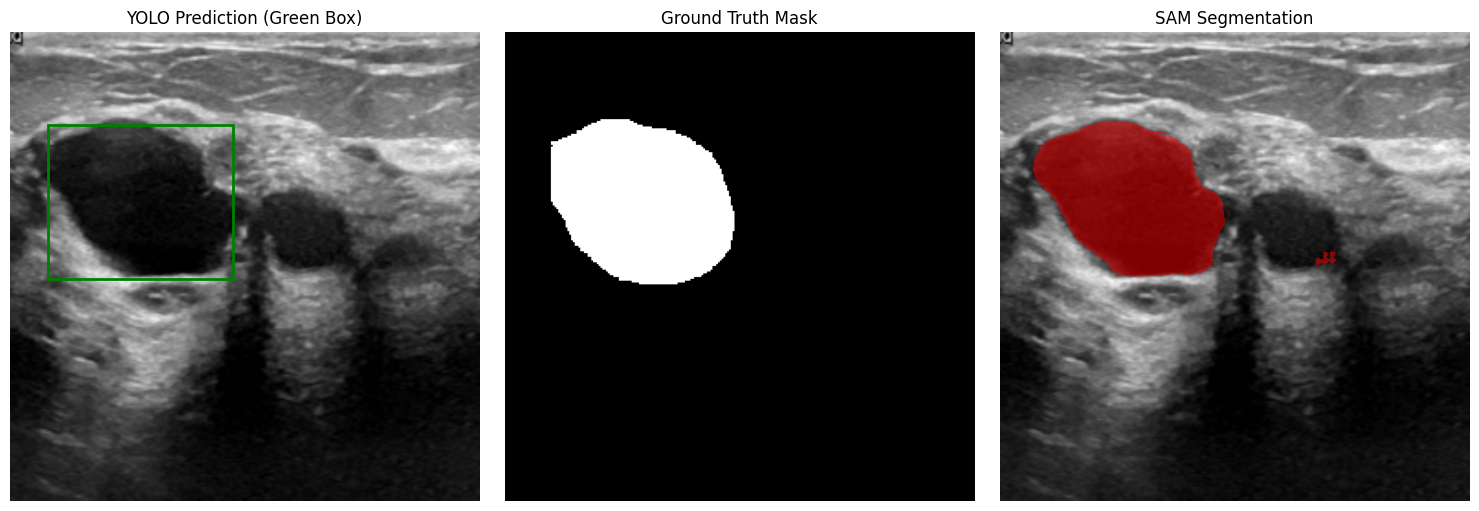


0: 416x416 5 tumors, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)


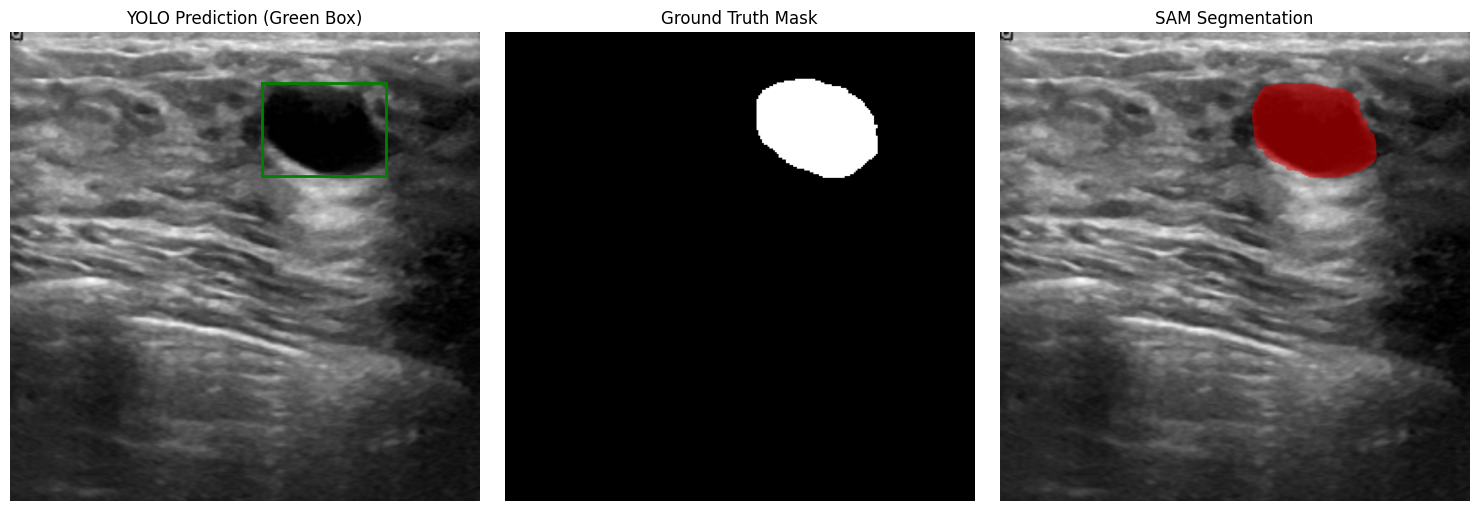


0: 416x416 6 tumors, 12.6ms
Speed: 1.5ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)


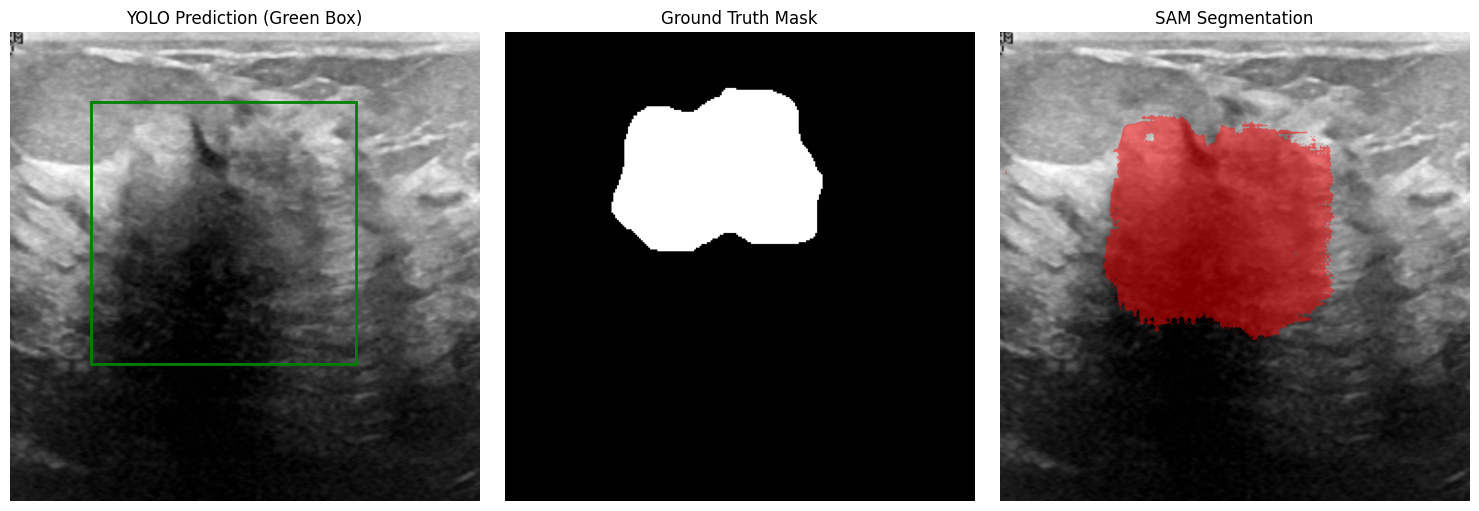


0: 416x416 5 tumors, 10.6ms
Speed: 1.2ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)


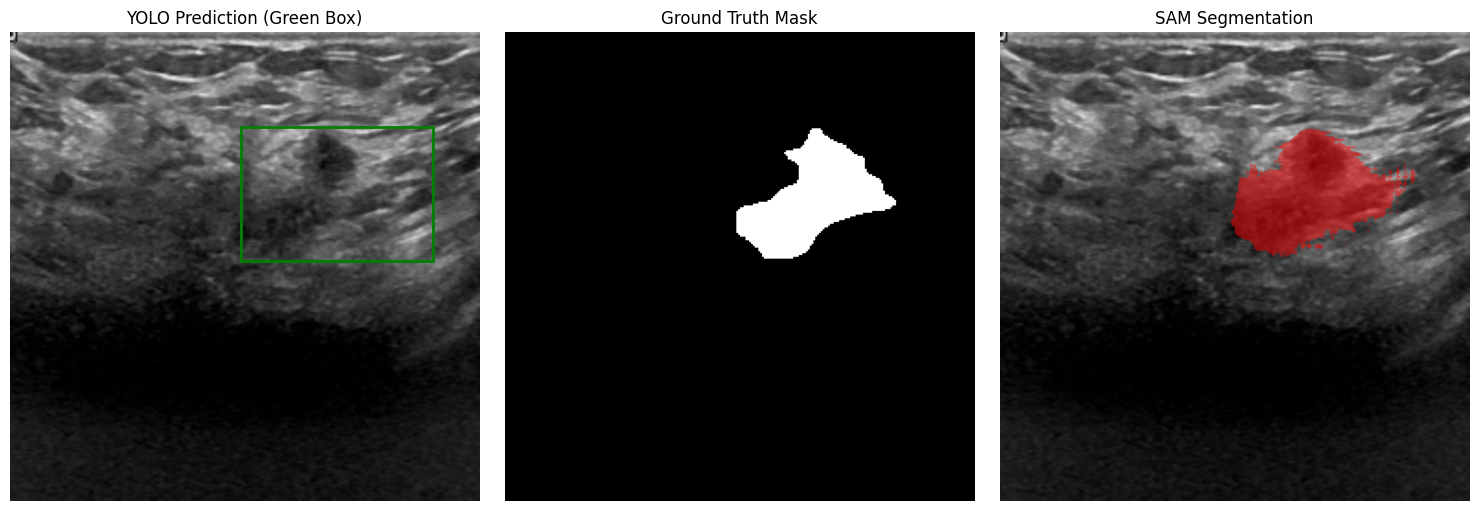


0: 416x416 12 tumors, 11.9ms
Speed: 1.5ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)


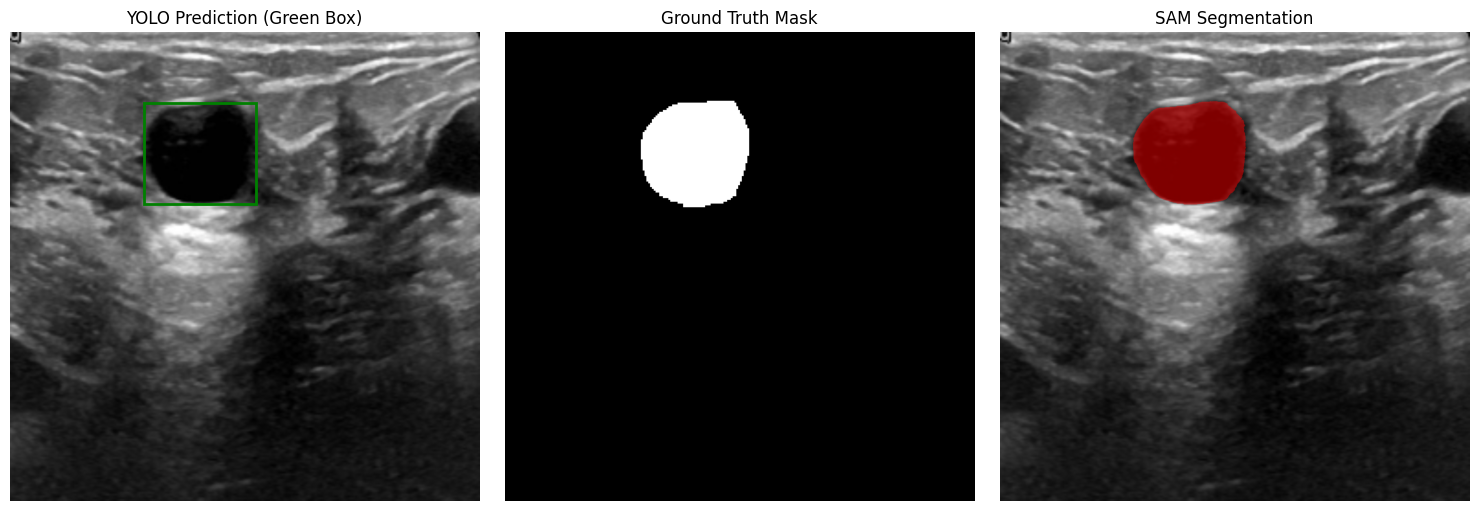


0: 416x416 14 tumors, 10.8ms
Speed: 1.1ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)


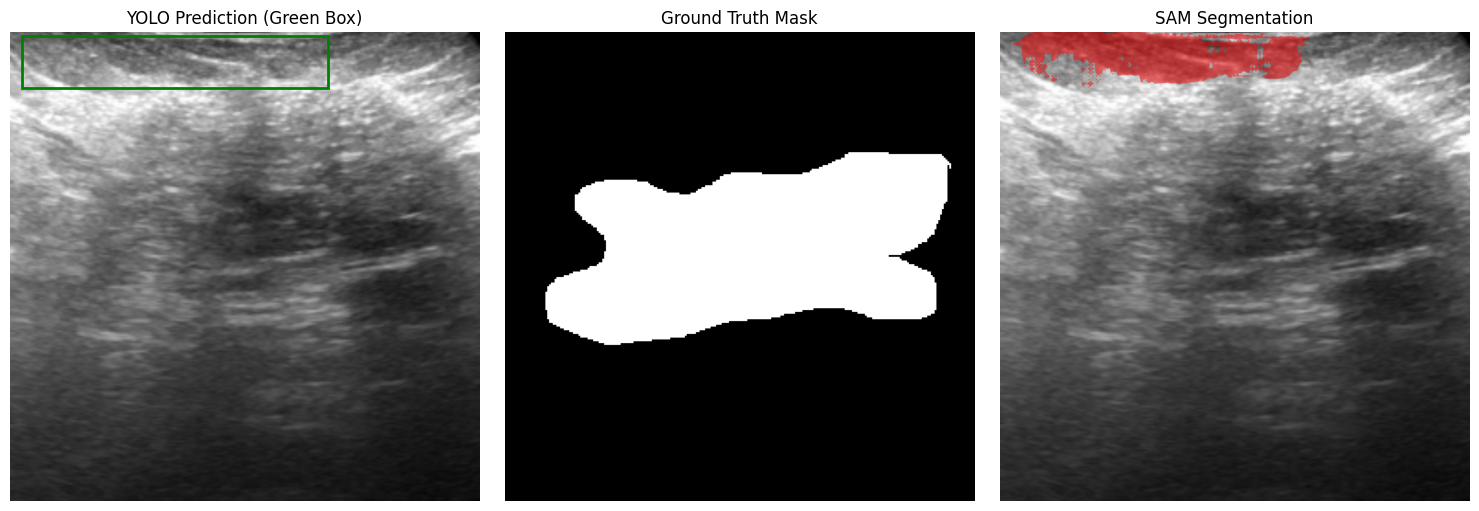


0: 416x416 3 tumors, 11.9ms
Speed: 1.8ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)


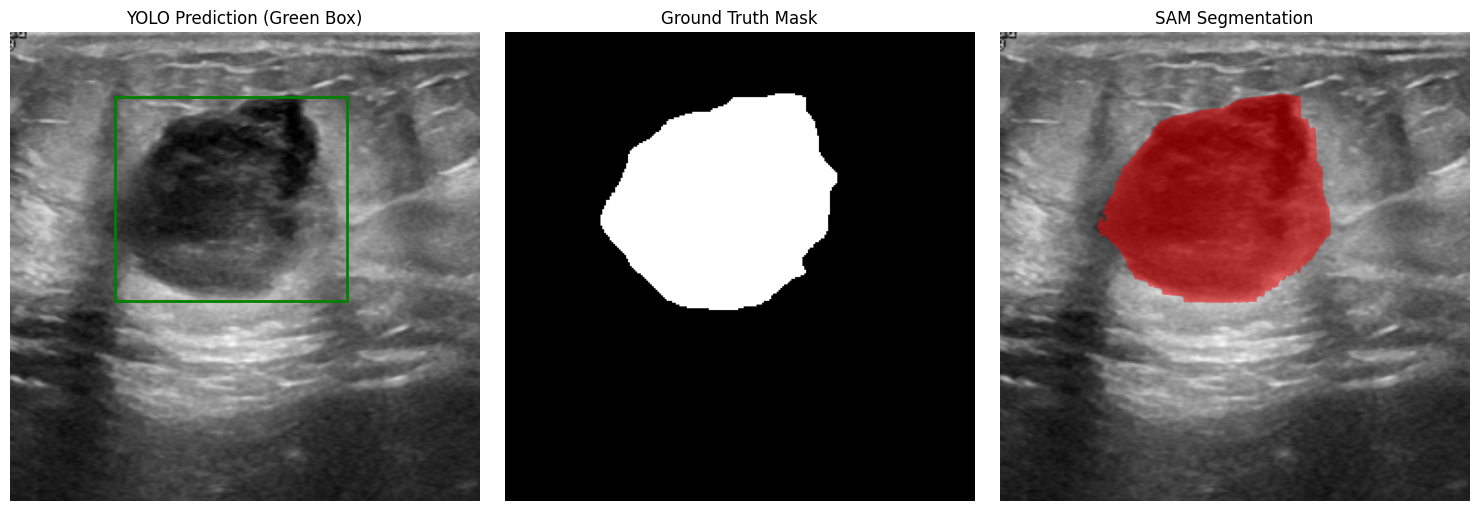


0: 416x416 5 tumors, 10.7ms
Speed: 1.7ms preprocess, 10.7ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)


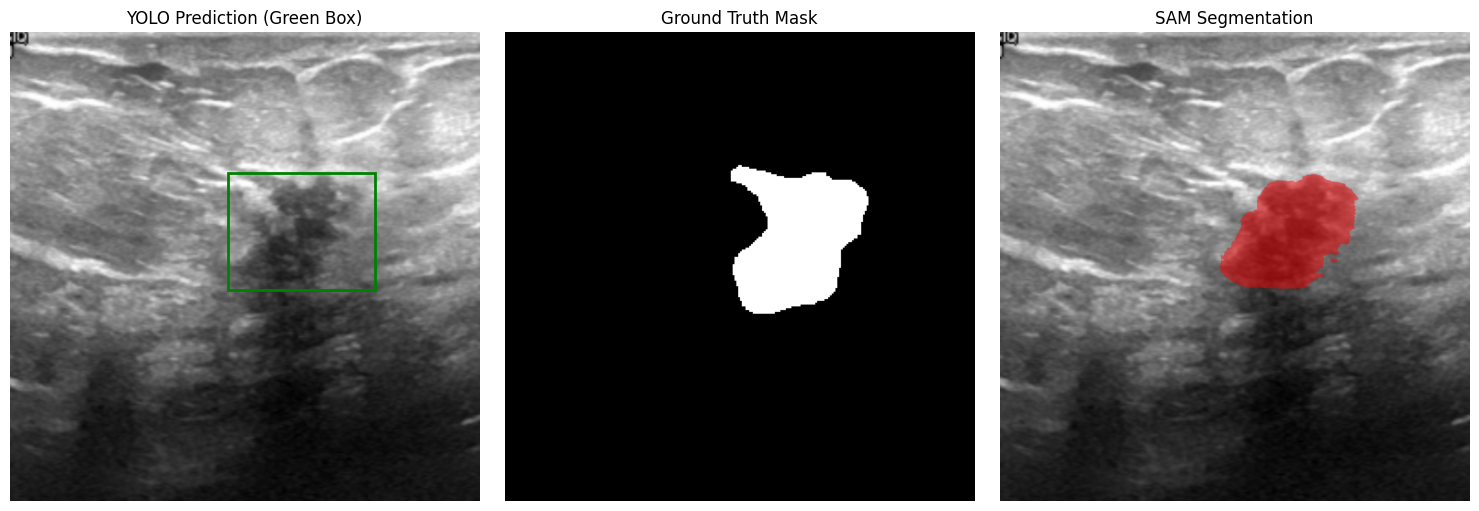


0: 416x416 7 tumors, 11.9ms
Speed: 1.5ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)


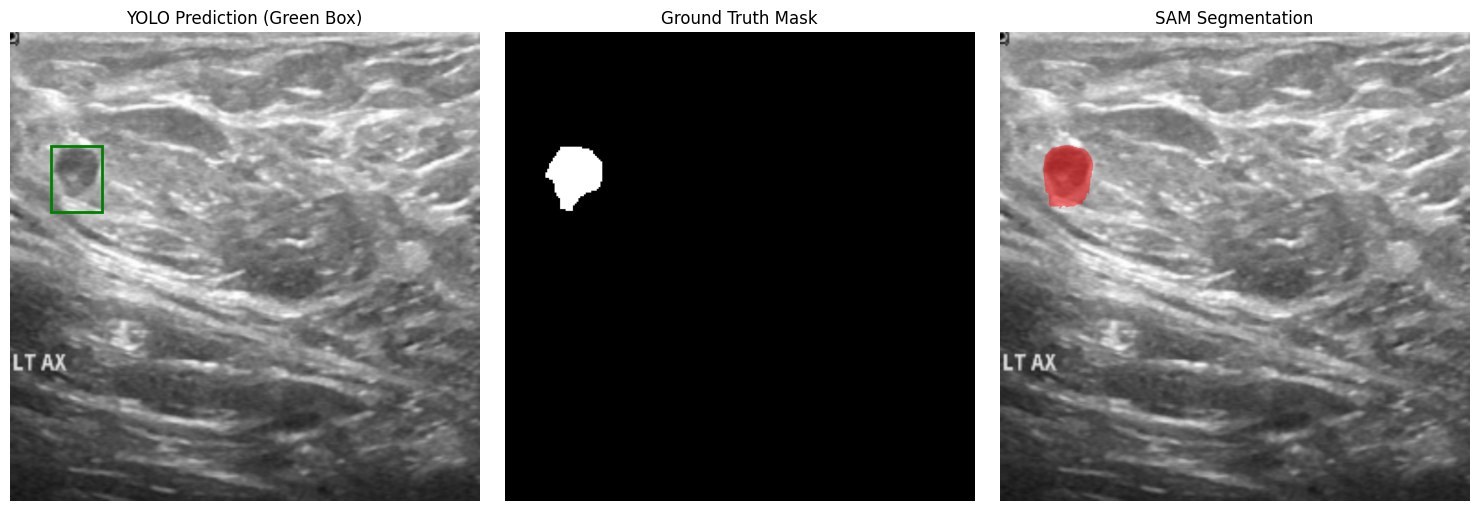


0: 416x416 4 tumors, 10.3ms
Speed: 1.1ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)


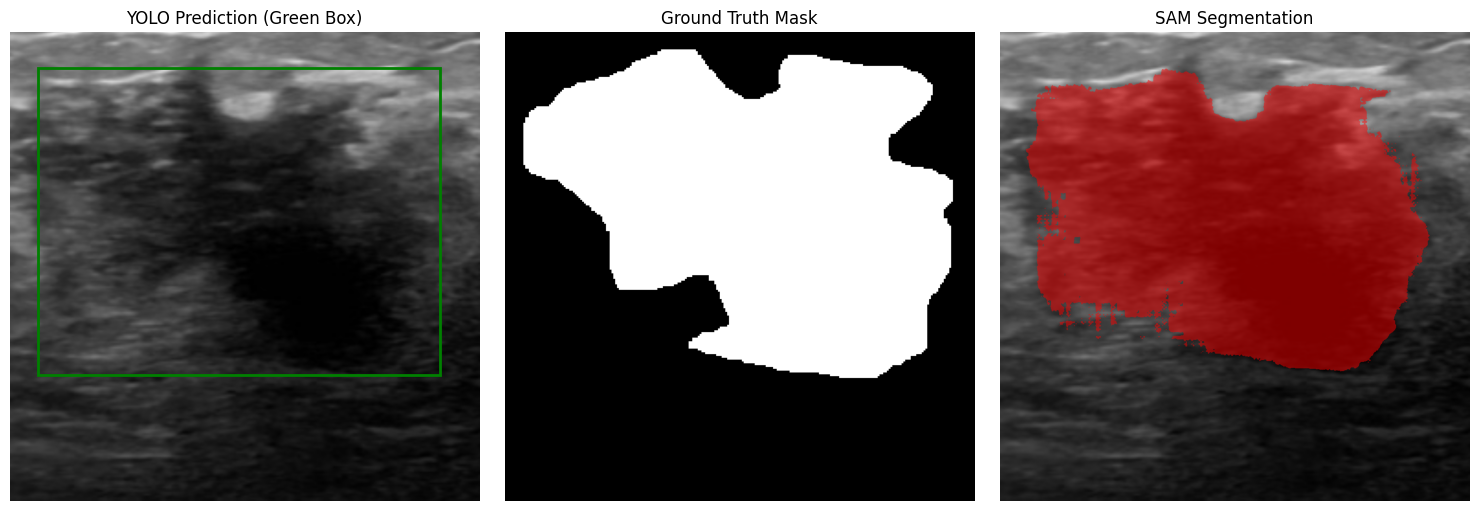


0: 416x416 1 tumor, 10.4ms
Speed: 1.0ms preprocess, 10.4ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)


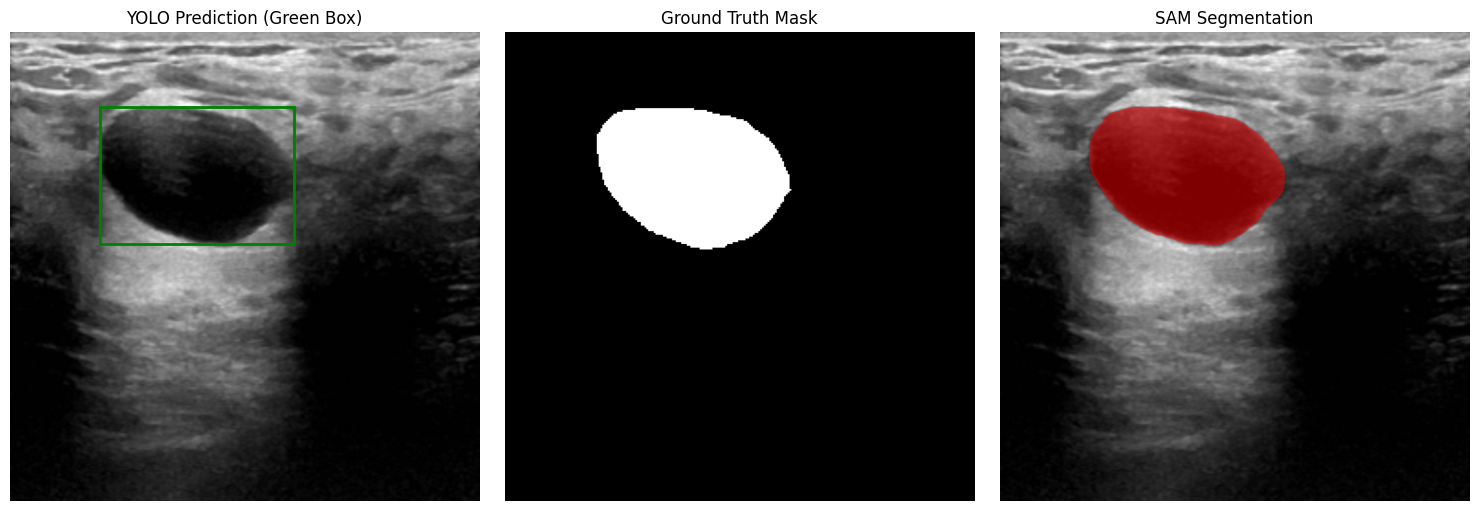


0: 416x416 5 tumors, 10.3ms
Speed: 1.3ms preprocess, 10.3ms inference, 2.5ms postprocess per image at shape (1, 3, 416, 416)


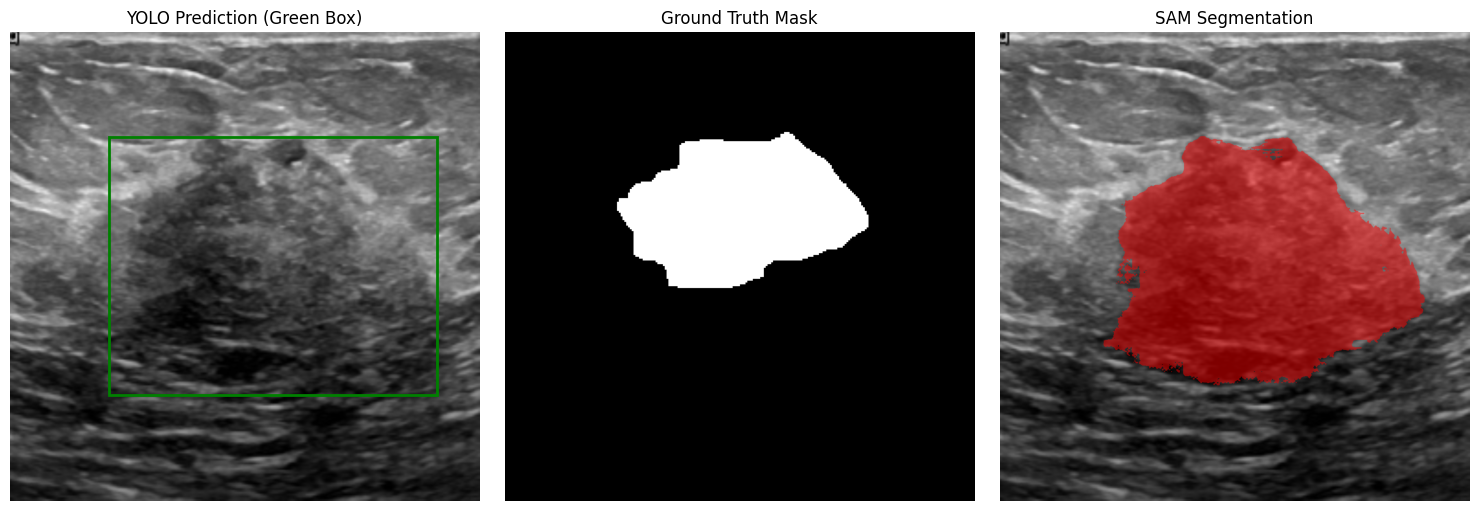


0: 416x416 6 tumors, 13.7ms
Speed: 1.2ms preprocess, 13.7ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 416)


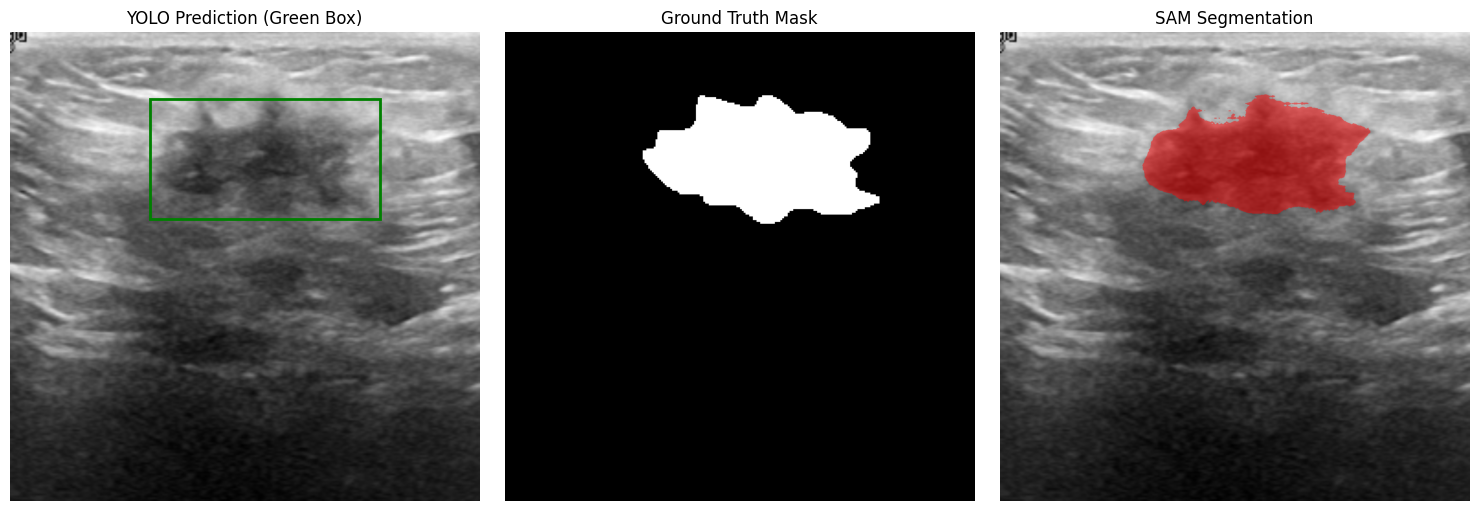


0: 416x416 6 tumors, 11.6ms
Speed: 1.7ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 416)


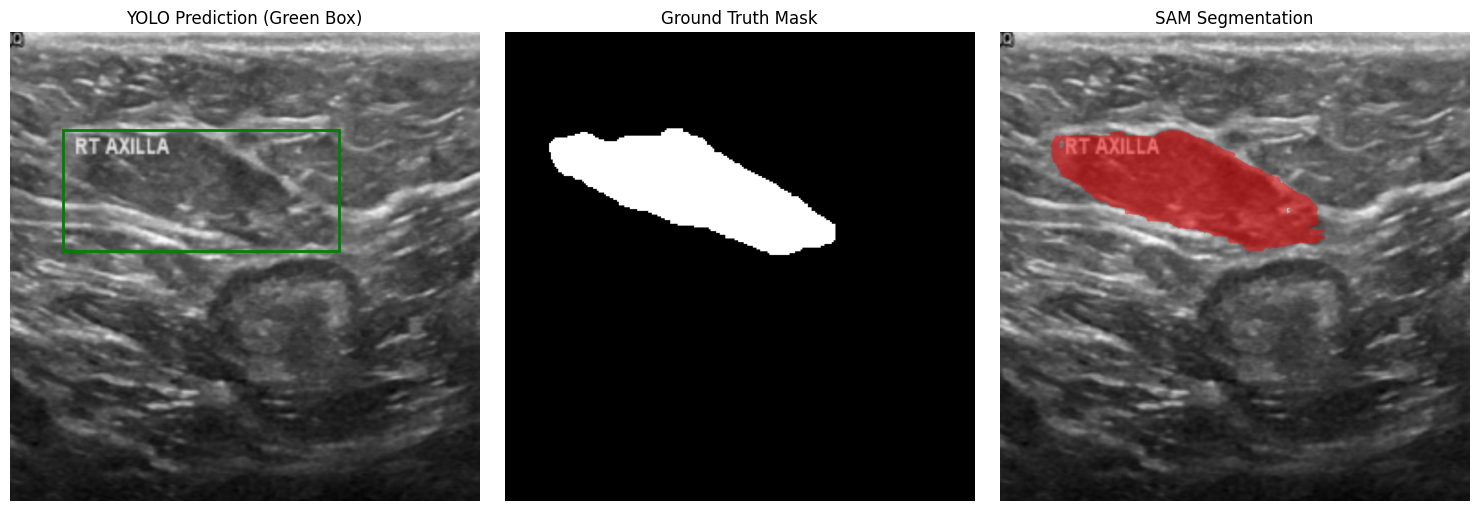


0: 416x416 21 tumors, 15.7ms
Speed: 2.2ms preprocess, 15.7ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)


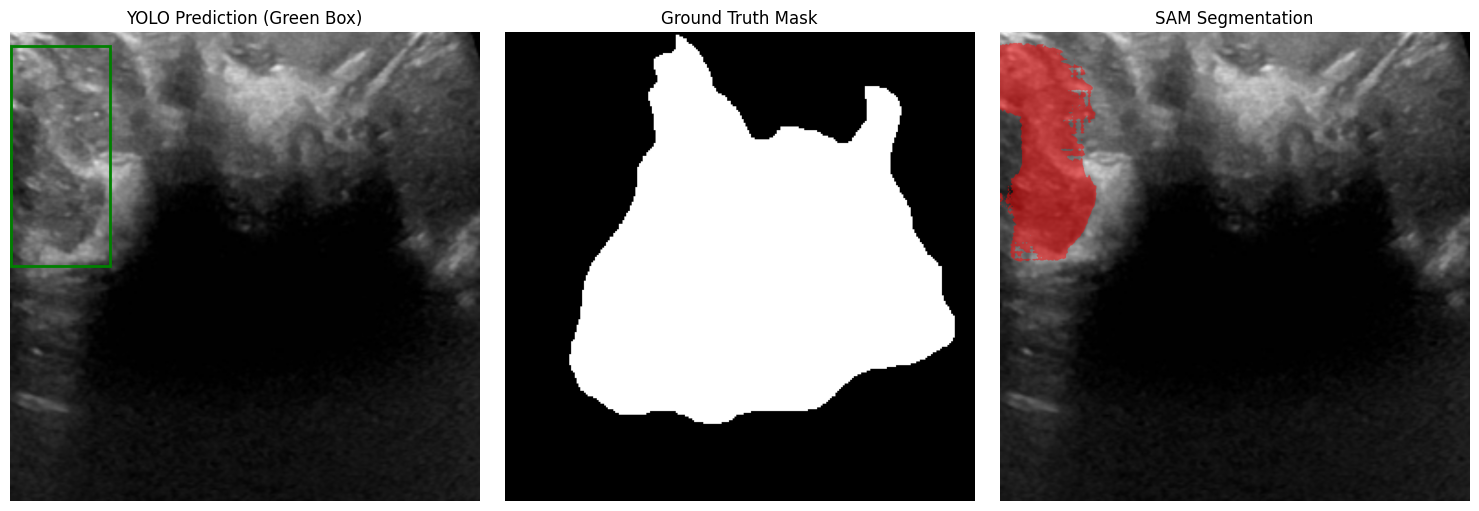


0: 416x416 1 tumor, 11.4ms
Speed: 1.7ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)


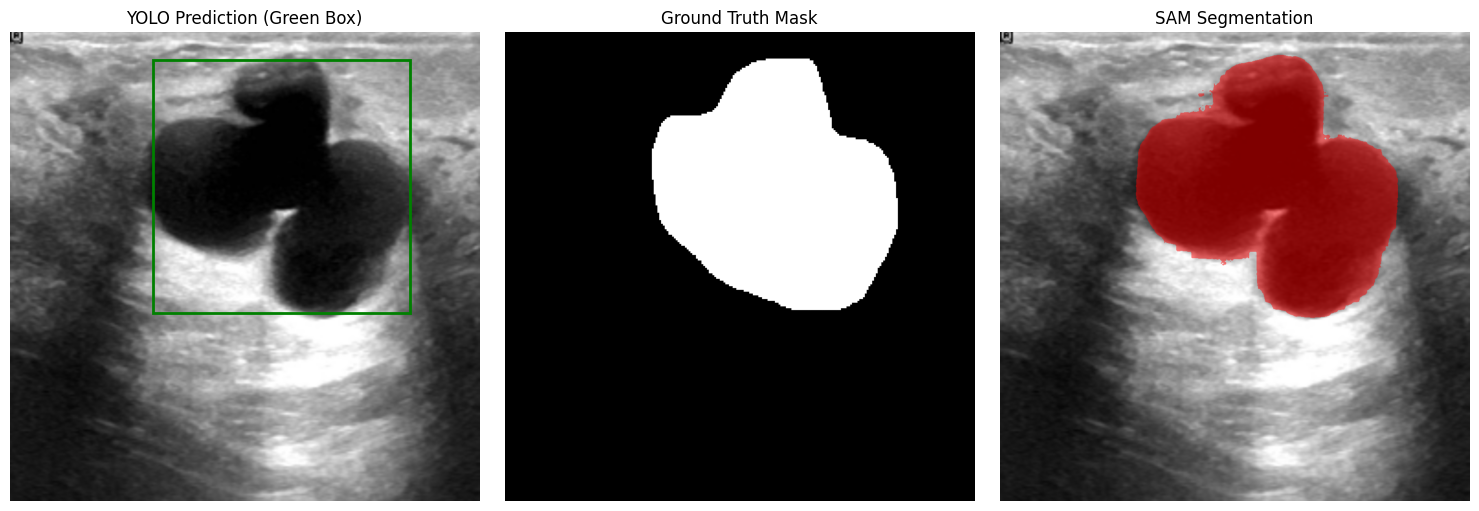

In [78]:
# Visualize YOLO bounding boxes and SAM segmentation on test set
import random
num_samples = 32  # Number of test samples to visualize
sample_indices = random.sample(range(len(test_dataset)), min(num_samples, len(test_dataset)))

import matplotlib.patches as patches

for idx in sample_indices:
    batch = test_dataset[idx]
    image_for_sam_np = batch["image_for_sam"]
    gt_mask = batch["gt_mask_tensor"].squeeze().numpy()
    img_yolo = image_for_sam_np
    h, w = img_yolo.shape[:2]

    # Get YOLO prediction
    results = model.predict(source=img_yolo, save=False, imgsz=416, conf=0.01, device=0)
    predicted_boxes = results[0].boxes
    nms_boxes = non_max_suppression(predicted_boxes, iou_threshold=0.2)
    if not nms_boxes:
        print(f"No YOLO box found for test sample {idx}. Skipping.")
        continue
    bbox = nms_boxes[0]
    if max(bbox) <= 1.0:
        x1 = int(bbox[0] * w)
        y1 = int(bbox[1] * h)
        x2 = int(bbox[2] * w)
        y2 = int(bbox[3] * h)
    else:
        x1, y1, x2, y2 = map(int, bbox)
    bbox_pixel = [x1, y1, x2, y2]

    # Run SAM segmentation with YOLO bbox
    bbox_prompt_tensor = torch.tensor([[x1, y1, x2, y2]], dtype=torch.float32, device=DEVICE)
    with torch.no_grad():
        predictor.set_image(img_yolo)
        boxes_for_encoder = bbox_prompt_tensor.unsqueeze(1)
        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(points=None, boxes=boxes_for_encoder, masks=None)
        high_res_features_test = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
        # Use image height and width for resizing
        target_hw = img_yolo.shape[0], img_yolo.shape[1]
        low_res_masks, _, _, _ = predictor.model.sam_mask_decoder(
            image_embeddings=predictor._features["image_embed"],
            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
            high_res_features=high_res_features_test,
            repeat_image=False
        )
        prd_masks_logits_upscaled = TF.resize(low_res_masks, list(target_hw),
                                              interpolation=TF.InterpolationMode.BILINEAR,
                                              antialias=True)
        pred_mask = torch.sigmoid(prd_masks_logits_upscaled).cpu().squeeze().numpy() > 0.5

    # Plot
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(img_yolo)
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='g', facecolor='none')
    axs[0].add_patch(rect)
    axs[0].set_title('YOLO Prediction (Green Box)')
    axs[0].axis('off')

    axs[1].imshow(gt_mask, cmap='gray')
    axs[1].set_title('Ground Truth Mask')
    axs[1].axis('off')

    # Create an RGBA mask for transparency
    mask_rgba = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 4), dtype=np.float32)
    mask_rgba[..., 0] = 1.0  # Red channel
    mask_rgba[..., 3] = pred_mask.astype(np.float32) * 0.5  # Alpha channel: 0.5 where mask==1, 0 where mask==0

    axs[2].imshow(img_yolo)
    axs[2].imshow(mask_rgba)
    axs[2].set_title('SAM Segmentation')
    axs[2].axis('off')
    plt.tight_layout()
    plt.show()